In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import warnings
import geopandas as gpd
from scipy.cluster import hierarchy
from sklearn import metrics
from scipy.cluster import vq
import sklearn.cluster as skc

import FINE as fn
import FINE.spagat.dataset as spd
import FINE.spagat.grouping as spg
import FINE.spagat.representation as spr 
import FINE.spagat.grouping_utils as gu
from FINE.IOManagement import dictIO
import FINE.IOManagement.xarrayIO as xrIO

from MATES import OptimizationManager



In [3]:
color_list = ['blue', 'purple', 'orange', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white', 
              'sky blue', 'brown', 'olive', 'aquamarine', 'pink']

In [4]:
import seaborn as sns
color_palette = sns.color_palette(None, 30)

In [5]:
color_palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

## dataset - multi_node_test_esM_init (Germany)

In [6]:
def getData():
    inputDataPath = r'C:\Users\s.patil\Documents\code\fine\examples\Multi-regional_Energy_System_Workflow\InputData'
    data = {}

    # Onshore data
    capacityMax = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'Wind', 'maxCapacityOnshore_GW_el.xlsx'),
                                index_col=0, squeeze=True)
    operationRateMax = pd.read_excel(
        os.path.join(inputDataPath, 'SpatialData_Germany', 'Wind', 'maxOperationRateOnshore_el.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'Wind (onshore), capacityMax': capacityMax})
    data.update({'Wind (onshore), operationRateMax': operationRateMax})

    # Offshore data
    capacityMax = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'Wind', 'maxCapacityOffshore_GW_el.xlsx'),
                                index_col=0, squeeze=True)
    operationRateMax = pd.read_excel(
        os.path.join(inputDataPath, 'SpatialData_Germany', 'Wind', 'maxOperationRateOffshore_el.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'Wind (offshore), capacityMax': capacityMax})
    data.update({'Wind (offshore), operationRateMax': operationRateMax})

    # PV data
    capacityMax = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'PV', 'maxCapacityPV_GW_el.xlsx'),
                                index_col=0, squeeze=True)
    operationRateMax = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'PV', 'maxOperationRatePV_el.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'PV, capacityMax': capacityMax})
    data.update({'PV, operationRateMax': operationRateMax})

    # Run of river data
    capacityFix = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'HydroPower', 'fixCapacityROR_GW_el.xlsx'),
                                index_col=0, squeeze=True)
    operationRateFix = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'HydroPower',
                                                  'fixOperationRateROR.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'Existing run-of-river plants, capacityFix': capacityFix})
    data.update({'Existing run-of-river plants, operationRateFix': operationRateFix})

    # Biogas data
    operationRateMax = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'Biogas',
                                                  'biogasPotential_GWh_biogas.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'Biogas, operationRateMax': operationRateMax})

    biogasCommodityCostTimeSeries = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'Biogas',
                                                  'biogasPriceTimeSeries_MrdEuro_GWh.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'Biogas, commodityCostTimeSeries': biogasCommodityCostTimeSeries})

    # Natural gas data
    naturalGasCommodityCostTimeSeries = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'NaturalGas',
                                                  'naturalGasPriceTimeSeries_MrdEuro_GWh.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'Natural Gas, commodityCostTimeSeries': naturalGasCommodityCostTimeSeries})

    # Natural gas plant data
    capacityMax = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'NaturalGasPlants',
                                             'existingCombinedCycleGasTurbinePlantsCapacity_GW_el.xlsx'),
                                index_col=0, squeeze=True)

    data.update({'Existing CCGT plants (methane), capacityMax': capacityMax})

    # Hydrogen salt cavern data
    capacityMax = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'GeologicalStorage',
                                             'existingSaltCavernsCapacity_GWh_methane.xlsx'),
                                index_col=0, squeeze=True) * 3 / 10

    data.update({'Salt caverns (hydrogen), capacityMax': capacityMax})

    # Methane salt cavern data
    capacityMax = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'GeologicalStorage',
                                             'existingSaltCavernsCapacity_GWh_methane.xlsx'),
                                index_col=0, squeeze=True)

    data.update({'Salt caverns (methane), capacityMax': capacityMax})

    # Pumped hydro storage data
    capacityFix = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'HydroPower',
                                             'fixCapacityPHS_storage_GWh_energyPHS.xlsx'),
                                index_col=0, squeeze=True)

    data.update({'Pumped hydro storage, capacityFix': capacityFix})

    # AC cables data
    capacityFix = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'ElectricGrid',
                                             'ACcableExistingCapacity_GW_el.xlsx'),
                                index_col=0, header=0)

    data.update({'AC cables, capacityFix': capacityFix})

    reactances = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'ElectricGrid',
                                            'ACcableReactance.xlsx'),
                                index_col=0, header=0)

    data.update({'AC cables, reactances': reactances})

    # DC cables data
    capacityFix = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'ElectricGrid',
                                             'DCcableExistingCapacity_GW_el.xlsx'),
                                index_col=0, header=0)
    distances = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'ElectricGrid',
                                           'DCcableLength_km.xlsx'),
                              index_col=0, header=0)
    losses = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'ElectricGrid',
                                        'DCcableLosses.xlsx'),
                           index_col=0, header=0)

    data.update({'DC cables, capacityFix': capacityFix})
    data.update({'DC cables, distances': distances})
    data.update({'DC cables, losses': losses})

    # Pipelines data
    eligibility = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'Pipelines',
                                             'pipelineIncidence.xlsx'), index_col=0, header=0)
    distances = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'Pipelines', 'pipelineLength.xlsx'),
                              index_col=0, header=0)

    data.update({'Pipelines, eligibility': eligibility})
    data.update({'Pipelines, distances': distances})

    # Electricity demand data
    operationRateFix = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'Demands',
                                                  'electricityDemand_GWh_el.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'Electricity demand, operationRateFix': operationRateFix})

    # Hydrogen demand data
    operationRateFix = pd.read_excel(os.path.join(inputDataPath, 'SpatialData_Germany', 'Demands',
                                                  'hydrogenDemand_GWh_hydrogen.xlsx'),
                                                  header = 0, index_col = 0)

    data.update({'Hydrogen demand, operationRateFix': operationRateFix})

    return data

In [7]:
data = getData()

In [8]:
# 2. Create an energy system model instance
locations = {'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'}
commodityUnitDict = {'electricity': r'GW$_{el}$', 'methane': r'GW$_{CH_{4},LHV}$', 'biogas': r'GW$_{biogas,LHV}$',
                         'CO2': r'Mio. t$_{CO_2}$/h', 'hydrogen': r'GW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen', 'methane', 'biogas', 'CO2'}
numberOfTimeSteps=8760
hoursPerTimeStep=1

esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                               commodityUnitsDict=commodityUnitDict,
                               hoursPerTimeStep=1, costUnit='1e9 Euro', lengthUnit='km', verboseLogLevel=0)

CO2_reductionTarget = 1


# 3. Add commodity sources to the energy system model
## 3.1. Electricity sources
### Wind onshore

esM.add(fn.Source(esM=esM, name='Wind (onshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (onshore), operationRateMax'],
                  capacityMax=data['Wind (onshore), capacityMax'],
                  investPerCapacity=1.1, opexPerCapacity=1.1*0.02, interestRate=0.08,
                  economicLifetime=20))

data['Wind (onshore), operationRateMax'].sum()


### Wind offshore

esM.add(fn.Source(esM=esM, name='Wind (offshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (offshore), operationRateMax'],
                  capacityMax=data['Wind (offshore), capacityMax'],
                  investPerCapacity=2.3, opexPerCapacity=2.3*0.02, interestRate=0.08,
                  economicLifetime=20))

data['Wind (offshore), operationRateMax'].sum()

### PV

esM.add(fn.Source(esM=esM, name='PV', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['PV, operationRateMax'], capacityMax=data['PV, capacityMax'],
                  investPerCapacity=0.65, opexPerCapacity=0.65*0.02, interestRate=0.08,
                  economicLifetime=25))

data['PV, operationRateMax'].sum()

### Exisisting run-of-river hydroelectricity plants

esM.add(fn.Source(esM=esM, name='Existing run-of-river plants', commodity='electricity',
                  hasCapacityVariable=True,
                  operationRateFix=data['Existing run-of-river plants, operationRateFix'], tsaWeight=0.01,
                  capacityFix=data['Existing run-of-river plants, capacityFix'],
                  investPerCapacity=0, opexPerCapacity=0.208))

## 3.2. Methane (natural gas and biogas)
### Natural gas
esM.add(fn.Source(esM=esM, name='Natural gas purchase', commodity='methane',
                  hasCapacityVariable=False, commodityCostTimeSeries=data['Natural Gas, commodityCostTimeSeries']))

### Biogas
esM.add(fn.Source(esM=esM, name='Biogas purchase', commodity='biogas',
                  operationRateMax=data['Biogas, operationRateMax'], hasCapacityVariable=False,
                  commodityCostTimeSeries=data['Biogas, commodityCostTimeSeries']))


## 3.3 CO2
### CO2

esM.add(fn.Source(esM=esM, name='CO2 from enviroment', commodity='CO2',
                  hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))


# 4. Add conversion components to the energy system model

### Combined cycle gas turbine plants

esM.add(fn.Conversion(esM=esM, name='CCGT plants (methane)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'methane':-1/0.625, 'CO2':201*1e-6/0.625},
                      hasCapacityVariable=True,
                      investPerCapacity=0.65, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))


### New combined cycle gas turbine plants for biogas

esM.add(fn.Conversion(esM=esM, name='New CCGT plants (biogas)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'biogas':-1/0.635},
                      hasCapacityVariable=True,
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))


### New combined cycly gas turbines for hydrogen

esM.add(fn.Conversion(esM=esM, name='New CCGT plants (hydrogen)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True,
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### Electrolyzers

esM.add(fn.Conversion(esM=esM, name='Electroylzers', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                      hasCapacityVariable=True,
                      investPerCapacity=0.5, opexPerCapacity=0.5*0.025, interestRate=0.08,
                      economicLifetime=10))

### rSOC

capexRSOC=1.5

esM.add(fn.Conversion(esM=esM, name='rSOEC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.6},
                      hasCapacityVariable=True,
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

esM.add(fn.Conversion(esM=esM, name='rSOFC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True,
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))


# 5. Add commodity storages to the energy system model
## 5.1. Electricity storage
### Lithium ion batteries

esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                   hasCapacityVariable=True, chargeEfficiency=0.95,
                   cyclicLifetime=10000, dischargeEfficiency=0.95, selfDischarge=1-(1-0.03)**(1/(30*24)),
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=0.151, opexPerCapacity=0.002, interestRate=0.08,
                   economicLifetime=22))

## 5.2. Hydrogen storage
### Hydrogen filled salt caverns

esM.add(fn.Storage(esM=esM, name='Salt caverns (hydrogen)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=133,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (hydrogen), capacityMax'],
                   investPerCapacity=0.00011, opexPerCapacity=0.00057, interestRate=0.08,
                   economicLifetime=30))


## 5.3. Methane storage
### Methane filled salt caverns

esM.add(fn.Storage(esM=esM, name='Salt caverns (biogas)', commodity='biogas',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=443,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (methane), capacityMax'],
                   investPerCapacity=0.00004, opexPerCapacity=0.00001, interestRate=0.08,
                   economicLifetime=30))


## 5.4 Pumped hydro storage
### Pumped hydro storage

esM.add(fn.Storage(esM=esM, name='Pumped hydro storage', commodity='electricity',
                   chargeEfficiency=0.88, dischargeEfficiency=0.88,
                   hasCapacityVariable=True, selfDischarge=1-(1-0.00375)**(1/(30*24)),
                   chargeRate=0.16, dischargeRate=0.12, capacityFix=data['Pumped hydro storage, capacityFix'],
                   investPerCapacity=0, opexPerCapacity=0.000153))


# 6. Add commodity transmission components to the energy system model
## 6.1. Electricity transmission
### AC cables

esM.add(fn.LinearOptimalPowerFlow(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix'],
                                  reactances=data['AC cables, reactances']))

### DC cables

esM.add(fn.Transmission(esM=esM, name='DC cables', commodity='electricity', losses=data['DC cables, losses'],
                        distances=data['DC cables, distances'],
                        hasCapacityVariable=True, capacityFix=data['DC cables, capacityFix']))


## 6.2 Methane transmission
### Methane pipeline

esM.add(fn.Transmission(esM=esM, name='Pipelines (biogas)', commodity='biogas',
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=False, bigM=300,
                            capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                            investPerCapacity=0.000037, investIfBuilt=0.000314,
                            interestRate=0.08, economicLifetime=40))

## 6.3 Hydrogen transmission
### Hydrogen pipelines

esM.add(fn.Transmission(esM=esM, name='Pipelines (hydrogen)', commodity='hydrogen',
                            distances=data['Pipelines, distances'],
                            hasCapacityVariable=True, hasIsBuiltBinaryVariable=False, bigM=300,
                            locationalEligibility=data['Pipelines, eligibility'],
                            capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                            investPerCapacity=0.000177, investIfBuilt=0.00033,
                            interestRate=0.08, economicLifetime=40))

# 7. Add commodity sinks to the energy system model
## 7.1. Electricity sinks
### Electricity demand

esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                    hasCapacityVariable=False, operationRateFix=data['Electricity demand, operationRateFix']))

## 7.2. Hydrogen sinks
### Fuel cell electric vehicle (FCEV) demand

FCEV_penetration=0.5
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                    operationRateFix=data['Hydrogen demand, operationRateFix']*FCEV_penetration))

## 7.3. CO2 sinks
### CO2 exiting the system's boundary

esM.add(fn.Sink(esM=esM, name='CO2 to enviroment', commodity='CO2',
                    hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

# 8. Optimize energy system model

# esM.cluster(numberOfTypicalPeriods=3)

# esM.optimize(timeSeriesAggregation=True, solver = solver)


The distances of a component are set to a normalized value of 1.


 c:\users\s.patil\documents\code\fine\FINE\utils.py:669: UserWarning:A declaration of bigM is not necessary if hasIsBuiltBinaryVariable is set to false. The value of bigM will be ignored in the optimization.
 c:\users\s.patil\documents\code\fine\FINE\utils.py:669: UserWarning:A declaration of bigM is not necessary if hasIsBuiltBinaryVariable is set to false. The value of bigM will be ignored in the optimization.


In [9]:
esM_Germany = esM

In [10]:
shp_Germany = 'C:/Users/s.patil/Documents/code/fine/examples/Multi-regional_Energy_System_Workflow/InputData/SpatialData_Germany/shapeFiles/clusteredRegions.shp'

## dataset - EuropeanModel

In [ ]:
# Input files

INPUT_PATH = 'C:/Users/s.patil/Documents/code/fine/examples/Multi-regional_Energy_System_Workflow/InputData/EuropeanModelData'

input_data = os.path.join(INPUT_PATH,'new_EuropeanScenario_Ch5_Section1_DGC.nc')
shp_Europe = os.path.join(INPUT_PATH,'supregions.shp')



In [ ]:
opM = OptimizationManager(input_data,
                          commodityUnitsDict={'electricity': 'GW_el', 
                                              'hydrogen': 'GW_h2', 
                                              'water': 'GW_wt', 
                                              'waterRes':'GW_wt', 
                                              'biomass':'GW_bio'})

In [ ]:
esM_Europe = opM.setup()

## Spatial grouping - sklearn hierarchical 

In [ ]:
aggregation_function_dict = {'operationRateMax': ('weighted mean', 'capacityMax'),#
                              'operationRateFix': ('sum', None),
                              'locationalEligibility': ('bool', None),
                              'capacityMax': ('sum', None),
                              'investPerCapacity': ('mean', None),
                              'investIfBuilt': ('bool', None),
                              'opexPerOperation': ('mean', None),
                              'opexPerCapacity': ('mean', None),
                              'opexIfBuilt': ('bool', None),
                              'interestRate': ('mean', None),
                              'economicLifetime': ('mean', None),
                              'capacityFix': ('sum', None),
                              'losses': ('mean', None),
                              'distances': ('mean', None),
                              'commodityCost': ('mean', None),
                              'commodityRevenue': ('mean', None),
                              'opexPerChargeOperation': ('mean', None),
                              'opexPerDischargeOperation': ('mean', None),
                              'QPcostScale': ('sum', None), 
                              'technicalLifetime': ('sum', None),
                              'reactances': ('sum', None), 
                              }

In [ ]:
def checkConnectivity(connectivity_matrix):
    is_diagonal_all_1 =  'all diagonal values are not 1' if any(a != 1 for a in np.diagonal(connectivity_matrix)) else 'all diagonal values are 1'
    is_symmetric = 'symmetric'if (connectivity_matrix == connectivity_matrix.T).all() else 'not symmetric'
    
    length = len(connectMatrix)
    is_connection = [] 
    for row in range(length):
        if np.count_nonzero(connectMatrix[row] == 1) > 1:
            is_connection.append(True)
        else:
            is_connection.append(False)
    
    if all(is_connection):
        connected = "all regions are connected"
    else:
        connected = f"regions are not connected. Hint: check region(s) at index {[i for i, x in enumerate(is_connection) if not x]}"
    
    print(f'In the connectivity matrix: {is_diagonal_all_1}, the matrix is {is_symmetric}, and {connected}') 
         

### Germany

In [ ]:
# #STEP 1. Read in the shapefile 
# gdfRegions = gpd.read_file(shp_Germany)

# #STEP 2. Obtain xr dataset from esM 
# sds = spd.SpagatDataset()
# esm_dict, comp_dict = dictIO.exportToDict(esM_Germany)
# sds.xr_dataset = xrIO.dimensional_data_to_xarray_dataset(esm_dict, comp_dict)

# #STEP 3. Add shapefile information to sds
# sds.add_objects(description='gpd_geometries',
#                 dimension_list=['space'],
#                 object_list=gdfRegions.geometry)
# spr.add_region_centroids(sds, spatial_dim='space')

In [ ]:
# #GROUPING
# dimension_description='space'
# regions_list = sds.xr_dataset[dimension_description].values
# n_regions = len(regions_list)

# aggregation_dict = {}
# aggregation_dict[n_regions] = {region_id: [region_id] for region_id in regions_list}  

# #STEP 0a. Preprocess the whole dataset with handle_mode='toDissimilarity'
# dict_ts, dict_1d, dict_2d = gu.preprocessDataset(sds, handle_mode='toDissimilarity') 

# #STEP 0b. Calculate the overall distance between each region pair (uses custom distance)
# precomputed_dist_matrix = gu.selfDistanceMatrix(dict_ts, dict_1d, dict_2d, n_regions)

In [ ]:
# connectMatrix = gu.generateConnectivityMatrix(sds)

In [ ]:
# connectMatrix

In [ ]:
# checkConnectivity(connectMatrix)

In [ ]:
# model = skc.AgglomerativeClustering(n_clusters=2,
#                                     affinity='precomputed',
#                                     linkage='average',
#                                     connectivity=connectMatrix).fit(precomputed_dist_matrix)

In [ ]:
# Output files 
n_regions = 7
groupingResult_xr_file = f'groupingResult_{n_regions}reg.nc4'
groupingResult_shp_file = f'groupingResult_{n_regions}reg.shp'

In [ ]:
aggregated_esM = esM_Germany.aggregateSpatially(shapefilePath = shp_Germany, 
                                                grouping_mode='all_variable_based', 
                                                nRegionsForRepresentation = n_regions,
                                                aggregatedResultsPath = '.',
                                                agg_mode='sklearn_hierarchical',
                                                sds_region_filename=groupingResult_shp_file,
                                                sds_xr_dataset_filename=groupingResult_xr_file) 

In [ ]:
# gpd.read_file(groupingResult_shp_file)

In [ ]:
fig, ax = fn.plotLocations(groupingResult_shp_file, 
                           plotLocNames=False, 
                           indexColumn='space',
                           faceColor=color_list)

In [ ]:
fig, ax = fn.plotLocations(shp_Germany, plotLocNames=True, indexColumn='index')

### Europe

In [ ]:
# #STEP 1. Read in the shapefile 
# gdfRegions = gpd.read_file(shp_Europe)

# #STEP 2. Obtain xr dataset from esM 
# sds = spd.SpagatDataset()
# esm_dict, comp_dict = dictIO.exportToDict(esM_Europe)
# sds.xr_dataset = xrIO.dimensional_data_to_xarray_dataset(esm_dict, comp_dict)

# #STEP 3. Add shapefile information to sds
# sds.add_objects(description='gpd_geometries',
#                 dimension_list=['space'],
#                 object_list=gdfRegions.geometry)
# spr.add_region_centroids(sds, spatial_dim='space')

In [ ]:
# #GROUPING
# dimension_description='space'
# regions_list = sds.xr_dataset[dimension_description].values
# n_regions = len(regions_list)

# aggregation_dict = {}
# aggregation_dict[n_regions] = {region_id: [region_id] for region_id in regions_list}  

# #STEP 0a. Preprocess the whole dataset with handle_mode='toDissimilarity'
# dict_ts, dict_1d, dict_2d = gu.preprocessDataset(sds, handle_mode='toDissimilarity') 

# #STEP 0b. Calculate the overall distance between each region pair (uses custom distance)
# precomputed_dist_matrix = gu.selfDistanceMatrix(dict_ts, dict_1d, dict_2d, n_regions)

In [ ]:
# connectMatrix = gu.generateConnectivityMatrix(sds)

In [ ]:
# Output files 
n_regions = 6
groupingResult_xr_file = f'groupingResult_{n_regions}reg.nc4'
groupingResult_shp_file = f'groupingResult_{n_regions}reg.shp'

In [ ]:
aggregated_esM = esM_Europe.aggregateSpatially(shapefilePath = shp_Europe, 
                                                grouping_mode='all_variable_based', 
                                                nRegionsForRepresentation = n_regions,
                                                aggregatedResultsPath = '.',
                                                agg_mode='sklearn_hierarchical',
                                                sds_region_filename=groupingResult_shp_file,
                                                sds_xr_dataset_filename=groupingResult_xr_file) 

In [ ]:
fig, ax = fn.plotLocations(groupingResult_shp_file, 
                           plotLocNames=False, 
                           indexColumn='space',
                          faceColor=color_palette)                         

In [ ]:


import os
import pytest

import xarray as xr

import FINE as fn

In [ ]:
aggregated_esM = esM_Germany.aggregateSpatially(shapefilePath = shp_Germany, 
                                                                grouping_mode = "distance_based", 
                                                                nRegionsForRepresentation = 4, 
                                                                aggregatedResultsPath=None)

In [ ]:
aggregated_esM

# Sklearn hierarchical 

In [11]:
#STEP 1. Read in the shapefile 
gdfRegions = gpd.read_file(shp_Germany)

#STEP 2. Obtain xr dataset from esM 
sds = spd.SpagatDataset()
esm_dict, comp_dict = dictIO.exportToDict(esM_Germany)
sds.xr_dataset = xrIO.dimensional_data_to_xarray_dataset(esm_dict, comp_dict)

#STEP 3. Add shapefile information to sds
sds.add_objects(description='gpd_geometries',
                dimension_list=['space'],
                object_list=gdfRegions.geometry)
spr.add_region_centroids(sds, spatial_dim='space')

 c:\users\s.patil\documents\code\fine\FINE\utils.py:1049: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\s.patil\documents\code\fine\FINE\utils.py:1049: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\s.patil\documents\code\fine\FINE\utils.py:1049: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\s.patil\documents\code\fine\FINE\utils.py:1049: UserWarning:Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
 c:\users\s.patil\documents\code\fine\FINE\utils.py:1049: UserWarning:Pandas doesn't allow columns to be created via a n

In [13]:
#GROUPING
dimension_description='space'
regions_list = sds.xr_dataset[dimension_description].values
n_regions = len(regions_list)

aggregation_dict = {}
aggregation_dict[n_regions] = {region_id: [region_id] for region_id in regions_list}  

#STEP 0a. Preprocess the whole dataset with handle_mode='toDissimilarity'
dict_ts, dict_1d, dict_2d = gu.preprocessDataset(sds) 

#STEP 0b. Calculate the overall distance between each region pair (uses custom distance)
precomputed_dist_matrix = gu.selfDistanceMatrix(dict_ts, dict_1d, dict_2d, n_regions)

 c:\users\s.patil\documents\code\fine\FINE\spagat\grouping_utils.py:237: UserWarning:Variable gpd_geometries has dimensions ('space',) which are not considered for spatial aggregation.
 c:\users\s.patil\documents\code\fine\FINE\spagat\grouping_utils.py:237: UserWarning:Variable gpd_centroids has dimensions ('space',) which are not considered for spatial aggregation.


In [ ]:
def checkConnectivity(region_index_x, region_index_y, ds_2d, connect_components): 
    """Checks if the given two regions are connected based on 2d-variables   
                                                  
    Parameters
    ----------
    region_index_x, region_index_y : int 
        Indicate the two regions between which the connectivity is to be checked 
        range of these indices - [0, n_regions)
    ds_2d : Dict 
        Dictionary obtained as a result of preprocess2dVariables() with handle_mode='toAffinity' 
    connect_components : List[int]
        List of component indices to be considered while checking for connectivity. 
        See generateConnectivityMatrix() for more information 
    
    Returns
    -------
    bool 
        True if a non-zero value is present for at least one component in `connect_components`,
        False otherwise 
    """  
    for var_dict in ds_2d.values():
        for c, data in var_dict.items():
            if (c in connect_components) and (data[region_index_x, region_index_y] != 0):  
                return True                              #INFO: checks for each var, each component. 
                                                         #      Returns TRUE if atleast one var, component pair has non-zero value.
                                                         # 
                                                         #
    return False   

In [ ]:
def parameter_based_clustering(sds,
                            dimension_description='space',
                            ax_illustration=None, 
                            save_path=None, 
                            fig_name=None,  
                            verbose=False):
    """Groups regions based on the Energy System Model instance's data. 

    Parameters #TODO: update this 
    ----------
    sds : Instance of SpagatDataset
        Refer to SpagatDataset class in dataset.py for more information 
    dimension_description : str, optional (default='space')
        The name/description of the dimension in the sds data that corresponds to regions 
    ax_illustration : Axis
        Provide axis to an existing figure, to include the generated plots to the same figure 
    save_path :  str, optional (default=None)
        The path to which to save the figure. 
        Valid only if `agg_mode` is 'scipy_hierarchical'
        If default None, figure is not saved
    fig_name : str, optional (default=None)
        Name of the saved figure. 
        Valid only if `save_path` is not None. 
        If default None, the figure is saved under the name 'scipy_hierarchical_dendrogram'    
    verbose : bool, optional (default=False)
        If True, the grouping results are printed. Supressed if False 
        
    Returns
    -------
    aggregation_dict : Dict[int, Dict[str, List[str]]]
        A nested dictionary containing results of spatial grouping at various levels/number of groups
        - Ex. {3: {'01_reg': ['01_reg'], '02_reg': ['02_reg'], '03_reg': ['03_reg']},
               2: {'01_reg_02_reg': ['01_reg', '02_reg'], '03_reg': ['03_reg']},
               1: {'01_reg_02_reg_03_reg': ['01_reg','02_reg','03_reg']}}
    
    Notes
    -----
    * While clustering/grouping regions, it is important to make sure that the regions 
      are spatially contiguous. Sklearn's agglomerative hierarchical clustering method is 
      capable of taking care of this if additional connectivity matrix is input. 
      This matrix should indicate which region pairs are connected (or contiguous).

    Overall steps involved:
        - Preprocessing data -> preprocessDataset() with handle_mode='toDissimilarity'
        - Custom distance -> selfDistanceMatrix()
        - Clustering method -> sklearn's agglomerative hierarchical clustering with average linkage  
        - Spatial contiguity -> Connectivity matrix is passed to the clustering method. 
                                generateConnectivityMatrix() to obtain Connectivity matrix.
        - Accuracy indicators -> (a) Cophenetic correlation coefficients are printed
                                (b) Inconsistencies are printed. 
                                (c) Silhouette scores are printed. 
    """

    # Original region list
    regions_list = sds.xr_dataset[dimension_description].values
    n_regions = len(regions_list)

    aggregation_dict = {}
    aggregation_dict[n_regions] = {region_id: [region_id] for region_id in regions_list}  #INFO: for 3 regions looks like -> 
                                                                                          # {3: {'01_reg': ['01_reg'], 
                                                                                          # '02_reg': ['02_reg'], 
                                                                                          # '03_reg': ['03_reg']}}. 
                                                                                          # Notice that it is dict within dict
    
    #STEP 1. Preprocess the whole dataset 
    dict_ts, dict_1d, dict_2d = gu.preprocessDataset(sds) 

    #STEP 2. Calculate the overall distance between each region pair (uses custom distance)
    precomputed_dist_matrix = gu.selfDistanceMatrix(dict_ts, dict_1d, dict_2d, n_regions)
    
    #STEP 3.  Obtain and check the connectivity matrix - indicates if a region pair is contiguous or not. 
    connectMatrix = gu.generateConnectivityMatrix(sds)

    #TODO: check connectivity and raise error if isolated regions are present 

    silhouette_scores = []

    #STEP 4. Clustering for every number of regions from 1 to one less than n_regions 
    for i in range(1,n_regions):           #NOTE: each level in the hierarchy shows one merge. Looks like here it does not. 
                                            #Hence, for loop is used to perform clustering for every number of desired regions 
                                            #TODO: maybe investigate this?

        #STEP 2a. Hierarchical clustering with average linkage
        model = skc.AgglomerativeClustering(n_clusters=i,
                                            affinity='precomputed',
                                            linkage='average',
                                            connectivity=connectMatrix).fit(precomputed_dist_matrix)
        regions_label_list = model.labels_

        #STEP 2b. Silhouette Coefficient score 
        if i != 1:
            s = metrics.silhouette_score(precomputed_dist_matrix, regions_label_list, metric='precomputed')
            silhouette_scores.append(s)

        #STEP 2c. Aggregated regions dict
        regions_dict = {}
        for label in range(i):
            # Group the regions of this regions label
            sub_regions_list = list(regions_list[regions_label_list == label])
            sup_region_id = '_'.join(sub_regions_list)
            regions_dict[sup_region_id] = sub_regions_list.copy()

        aggregation_dict[i] = regions_dict.copy()

    #STEP 3. Plot the hierarchical tree dendrogram
    clustering_tree = skc.AgglomerativeClustering(distance_threshold=0, 
                                                    n_clusters=None, 
                                                    affinity='precomputed', 
                                                    linkage='average',
                                                    connectivity=connectMatrix).fit(precomputed_dist_matrix)

    #STEP 4. Cophenetic correlation coefficient                                              
    counts = np.zeros(clustering_tree.children_.shape[0])
    n_samples = len(clustering_tree.labels_)
    for i, merge in enumerate(clustering_tree.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
        
    linkage_matrix = np.column_stack([clustering_tree.children_, clustering_tree.distances_, counts]).astype(float)   
    
    distance_matrix = hierarchy.distance.squareform(precomputed_dist_matrix)
    print('The cophenetic correlation coefficient of the hiearchical clustering is ', hierarchy.cophenet(linkage_matrix, distance_matrix)[0])
    
    #STEP 5. Check for inconsistency                        #TODO: more info regarding this should be displayed. Otherwise, it is not very informative
    inconsistency = hierarchy.inconsistent(linkage_matrix)
    print('Inconsistencies:',list(inconsistency[:,3]))
    
    #STEP 6. Print Silhouette scores 
    print('Silhouette scores: ',silhouette_scores)


    return aggregation_dict

In [34]:
ds_extracted = sds.xr_dataset

In [35]:
ds_extracted

<xarray.Dataset>
Dimensions:                       (Period: 1, TimeStep: 8760, component: 24, space: 8, space_2: 8)
Coordinates:
  * component                     (component) object 'Conversion, CCGT plants...
  * Period                        (Period) int64 0
  * TimeStep                      (TimeStep) int64 0 1 2 3 ... 8757 8758 8759
  * space                         (space) object 'cluster_0' ... 'cluster_7'
  * space_2                       (space_2) object 'cluster_0' ... 'cluster_7'
Data variables:
    ts_operationRateMax           (component, Period, TimeStep, space) float64 ...
    ts_operationRateFix           (component, Period, TimeStep, space) float64 ...
    ts_commodityCostTimeSeries    (component, Period, TimeStep, space) float64 ...
    2d_locationalEligibility      (component, space, space_2) float64 nan ......
    2d_capacityMax                (component, space, space_2) float64 nan ......
    2d_investPerCapacity          (component, space, space_2) float64 nan ......
    2d_investIfBuilt              (component, space, space_2) float64 nan ......
    2d_opexPerOperation           (component, space, space_2) float64 nan ......
    2d_opexPerCapacity            (component, space, space_2) float64 nan ......
    2d_opexIfBuilt                (component, space, space_2) float64 nan ......
    2d_QPcostScale                (component, space, space_2) float64 nan ......
    2d_interestRate               (component, space, space_2) float64 nan ......
    2d_economicLifetime           (component, space, space_2) float64 nan ......
    2d_technicalLifetime          (component, space, space_2) float64 nan ......
    2d_capacityFix                (component, space, space_2) float64 nan ......
    2d_reactances                 (component, space, space_2) float64 nan ......
    2d_losses                     (component, space, space_2) float64 nan ......
    2d_distances                  (component, space, space_2) float64 nan ......
    1d_locationalEligibility      (component, space) float64 1.0 1.0 ... nan nan
    1d_capacityMax                (component, space) float64 nan nan ... nan nan
    1d_investPerCapacity          (component, space) float64 0.65 0.65 ... nan
    1d_investIfBuilt              (component, space) float64 0.0 0.0 ... nan nan
    1d_opexPerOperation           (component, space) float64 0.0 0.0 ... nan nan
    1d_commodityCost              (component, space) float64 nan nan ... nan nan
    1d_commodityRevenue           (component, space) float64 nan nan ... nan nan
    1d_opexPerCapacity            (component, space) float64 0.021 0.021 ... nan
    1d_opexIfBuilt                (component, space) float64 0.0 0.0 ... nan nan
    1d_QPcostScale                (component, space) float64 0.0 0.0 ... nan nan
    1d_interestRate               (component, space) float64 0.08 0.08 ... nan
    1d_economicLifetime           (component, space) float64 33.0 33.0 ... nan
    1d_technicalLifetime          (component, space) float64 33.0 33.0 ... nan
    1d_capacityFix                (component, space) float64 nan nan ... nan nan
    1d_opexPerChargeOperation     (component, space) float64 nan nan ... nan nan
    1d_opexPerDischargeOperation  (component, space) float64 nan nan ... nan nan
    gpd_geometries                (space) object MULTIPOLYGON (((4223496.0915...
    gpd_centroids                 (space) object POINT (4225219.489523996 292...

In [68]:
def generateConnectivityMatrix(sds):
    """Generates connectiviy matrix. 
        - In this matrix, if two regions are connected, it is indicated as 1 and 0 otherwise. 
        - For every region pair, as long as they have atleast one non-zero 2d-variable value, 
          related to 'pipeline' component, they are regarded as connected.
        - If no component related to 'pipeline' is present in the data, then all components
          are considered.
                                                      
    Parameters
    ----------
    sds : Instance of SpagatDataset
        Refer to SpagatDataset class in dataset.py for more information
    
    Returns
    -------
    adjacencyMatrix : np.ndarray 
        A n_regions by n_regions symmetric matrix 
    """
    ds_extracted = sds.xr_dataset
    
    n_regions = len(ds_extracted['space'].values)
#     component_list = list(ds_extracted['component'].values)
#     n_components = len(component_list)
    
    #STEP 1: Check for contiguous neighbors 
    connectivity_matrix = np.zeros((n_regions,n_regions))
    
    geometries = gpd.GeoSeries(ds_extracted['gpd_geometries']) #NOTE: disjoint seems to work only on geopandas or geoseries object
    for ix, geom in enumerate(geometries):
        neighbors = geometries[~geometries.disjoint(geom)].index.tolist()
        print(neighbors)
        print('-----------------------------------------------------------')
        connectivity_matrix[ix, neighbors] = 1
    return(connectivity_matrix)

        
    
    
    
    

#     vars_2d = {}

#     for varname, da in ds_extracted.data_vars.items():
#         if da.dims == ('component','space','space_2'):
#             vars_2d[varname] = da

    

#     #STEP 1. Preprocess 2d variables #TODO: why is this required again? isn't this done initially ?
#     ds_2d = preprocess2dVariables(vars_2d, n_components, handle_mode='toAffinity') #TODO: This needs to be changed toAffinity 
#                                                                                    # does not exit anymore 

#     #STEP 2. First check if a component called 'pipeline' exists.
#     # If it does, take it as connect_components
#     connect_components = []
#     for i in range(n_components):            
#         if 'pipeline' in component_list[i].lower():
#             connect_components.append(i)

#     #STEP 3. If 'pipeline' does not exist, consider all existing components.
#     if not connect_components:
#         connect_components = list(range(n_components))  

#     adjacencyMatrix = np.zeros((n_regions,n_regions))
#     # For each region pair checkConnectivity (call the function)
#     for i in range(n_regions):
#         for j in range(i+1,n_regions):
#             if checkConnectivity(i,j, ds_2d, connect_components):  #INFO: checkConnectivity returns true or false 
#                 adjacencyMatrix[i,j] = 1

#     #STEP 4. adjacencyMatrix is upper triangular. 
#     # so, take transpose, subtract the diagonal elements and add it back to adjacencyMatrix. 
#     # Now, it is symmetrical
#     adjacencyMatrix += adjacencyMatrix.T - np.diag(adjacencyMatrix.diagonal())  

#     #STEP 5. Set the diagonal values to 1
#     np.fill_diagonal(adjacencyMatrix, 1)  

    return adjacencyMatrix

In [69]:
generateConnectivityMatrix(sds)

[0, 1, 2, 4, 5, 7]
-----------------------------------------------------------
[0, 1, 2, 3, 5, 6]
-----------------------------------------------------------
[0, 1, 2, 7]
-----------------------------------------------------------
[1, 3, 5, 6]
-----------------------------------------------------------
[0, 4, 5]
-----------------------------------------------------------
[0, 1, 3, 4, 5]
-----------------------------------------------------------
[1, 3, 6]
-----------------------------------------------------------
[0, 2, 7]
-----------------------------------------------------------


array([[1., 1., 1., 0., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0., 1., 1., 0.],
       [1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 1., 1., 0.],
       [1., 0., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 1., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0., 1., 0.],
       [1., 0., 1., 0., 0., 0., 0., 1.]])

In [57]:
geometries = gpd.GeoSeries(ds_extracted['gpd_geometries']) #NOTE: disjoint seems to work only on geopandas or geoseries object
for geom in geometries:
    neighbors = geometries[~geometries.disjoint(geom)]
    print(neighbors)
    

0    MULTIPOLYGON (((4223496.092 2734368.143, 42236...
1    MULTIPOLYGON (((4199685.633 3404002.686, 41996...
2    MULTIPOLYGON (((4106781.295 3394915.767, 41067...
4    POLYGON ((4553700.750 2730225.831, 4553786.048...
5    POLYGON ((4571189.891 3067926.848, 4571184.381...
7    MULTIPOLYGON (((4039023.418 2970178.496, 40390...
dtype: geometry
0    MULTIPOLYGON (((4223496.092 2734368.143, 42236...
1    MULTIPOLYGON (((4199685.633 3404002.686, 41996...
2    MULTIPOLYGON (((4106781.295 3394915.767, 41067...
3    MULTIPOLYGON (((4602449.935 3408647.034, 46024...
5    POLYGON ((4571189.891 3067926.848, 4571184.381...
6    MULTIPOLYGON (((4235203.262 3440768.058, 42352...
dtype: geometry
0    MULTIPOLYGON (((4223496.092 2734368.143, 42236...
1    MULTIPOLYGON (((4199685.633 3404002.686, 41996...
2    MULTIPOLYGON (((4106781.295 3394915.767, 41067...
7    MULTIPOLYGON (((4039023.418 2970178.496, 40390...
dtype: geometry
1    MULTIPOLYGON (((4199685.633 3404002.686, 41996...
3    MULTIPOLYGON

In [33]:
import geopandas as gpd

# open file
gdf = gpd.read_file(shp_Germany)

# add NEIGHBORS column
gdf["NEIGHBORS"] = None  

for ix, row in gdf.iterrows():   
    print(row['index'])
    #print(f'neighbors of {}:')
    # get 'not disjoint' countries
    neighbors = gdf[~gdf.geometry.disjoint(row.geometry)] #.index.tolist()
    print(neighbors.index)
    print('----------------------------------------------------------')

    # remove own name of the country from the list
    #neighbors = [ name for name in neighbors if region.index != name ]

    # add names of neighbors as NEIGHBORS value
    #gdf.at[ix, "NEIGHBORS"] = ", ".join(neighbors)

cluster_0
Int64Index([0, 1, 2, 4, 5, 7], dtype='int64')
----------------------------------------------------------
cluster_1
Int64Index([0, 1, 2, 3, 5, 6], dtype='int64')
----------------------------------------------------------
cluster_2
Int64Index([0, 1, 2, 7], dtype='int64')
----------------------------------------------------------
cluster_3
Int64Index([1, 3, 5, 6], dtype='int64')
----------------------------------------------------------
cluster_4
Int64Index([0, 4, 5], dtype='int64')
----------------------------------------------------------
cluster_5
Int64Index([0, 1, 3, 4, 5], dtype='int64')
----------------------------------------------------------
cluster_6
Int64Index([1, 3, 6], dtype='int64')
----------------------------------------------------------
cluster_7
Int64Index([0, 2, 7], dtype='int64')
----------------------------------------------------------


In [49]:
~gdf.geometry

TypeError: bad operand type for unary ~: 'GeometryArray'

In [18]:
gdf = gpd.read_file(shp_Germany)

In [52]:
type(gdf.geometry)

geopandas.geoseries.GeoSeries

 c:\users\s.patil\documents\code\fine\FINE\IOManagement\standardIO.py:659: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\s.patil\documents\code\fine\FINE\IOManagement\standardIO.py:659: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\s.patil\documents\code\fine\FINE\IOManagement\standardIO.py:659: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\users\s.patil\documents\code\fine\FINE\IOManagement\standardIO.py:659: MatplotlibDeprecationWarning:The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
 c:\

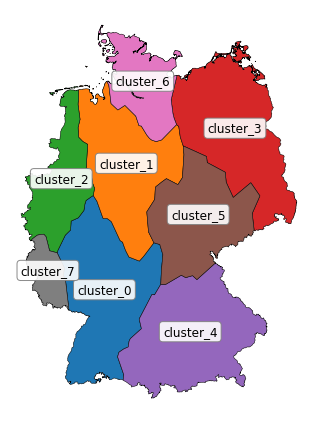

In [29]:
fig, ax = fn.plotLocations(shp_Germany, 
                           plotLocNames=True, 
                           indexColumn='index',
                          faceColor=color_palette)                         